<h1 align="center" style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">MSc in Data Analytics: Big Data Storage and Processing</h1>

### Table of Contents

- [Introduction](#Introduction)
    - [Assessment Overview](#Assessment-Overview)
    - [Project Summary](#Project-Summary)

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Introduction</h2>

### **Assessment Overview**

### Project Summary

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Install and Import Required Libraries</h2>

In [1]:
# !pip install -q pyspark pymongo

In [2]:
import glob
import os
from datetime import datetime
import logging

import numpy as np
import pandas as pd

import pymongo
from pymongo import MongoClient


from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import lit

from kaggle_secrets import UserSecretsClient

import warnings

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s — %(levelname)s %(message)s', force=True)
logger = logging.getLogger(__name__)

# Disable warnings
warnings.filterwarnings(action='ignore')

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Define Data Paths</h2>

In [4]:
STOCKPRICE_FOLDER = "/kaggle/input/stock-tweet-and-price/stock-tweet-and-price/stockprice"
STOCKTWEET_CSV = "/kaggle/input/stock-tweet-and-price/stock-tweet-and-price/stocktweet/stocktweet.csv"

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Set MongoDB Connection</h2>

In [5]:
user_secrets = UserSecretsClient()
mongodb_uri = user_secrets.get_secret("mongodb-atlas-uri")

In [6]:
def create_mongodb_connection(uri, db_name='stock_analytics'):
    """
    Connect to MongoDB and return database instance
    
    Args:
        uri (str): Database URI
        db_name (str): Database name
    
    Returns:
        pymongo.database.Database: MongoDB database instance
    """
    try:
        client = MongoClient(uri)
        db = client[db_name]
        print("MongoDB version:", client.server_info()["version"])
        logger.info(f"Connected to MongoDB database: {db_name}")
        return db
    except Exception as e:
        logger.error(f"Failed to connect to MongoDB: {e}")
        raise

db = create_mongodb_connection(mongodb_uri, 'stock_analytics')

2025-07-14 18:39:34,449 — INFO Connected to MongoDB database: stock_analytics


MongoDB version: 8.0.11


### MongoDB Selection Rationale

**Why MongoDB was chosen over other NoSQL options:**


* **Document-oriented structure**

  * MongoDB’s JSON-like document model naturally accommodates the semi-structured `stocktweet.csv` data (e.g., tweet text, ticker, and timestamp).
  * No need for complex schema definitions or rigid table structures.

* **Ease of use and developer-friendliness**
  * It is easy to get started with MongoDB. The installation process is easy as well as connecting to the database
  * MongoDB’s query language (MQL) is intuitive and similar to JSON syntax, which makes it easy to write.
  * Rich developer tools such as MongoDB Compass which helps me visualize the database. E.g when I have created a collection, inserted a data, and so on.
  * Extensive support for multiple programming languages (e.g., Python, Java, Scala).

* **Seamless integration with Apache Spark**

  * The `mongo-spark-connector` enables direct read/write access between MongoDB and Spark DataFrames.
  * Simplifies data ingestion, distributed transformation, and analytics within the Spark environment.

* **Efficient for read-heavy analytical workloads**

  * MongoDB supports secondary indexing and text search—ideal for querying tweets by ticker symbol or date.
  * Aggregation pipelines allow for efficient summarization and filtering of large datasets.

* **Cloud accessibility and scalability**

  * MongoDB Atlas provides a fully managed cloud database service that allows me to connect securely from anywhere.
  * I can easily deploy and scale MongoDB clusters in the cloud and integrate them with my local Spark environment.
  * Atlas ensures high availability, backup, and monitoring, which is ideal for handling large-scale, real-time tweet and stock data.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Create Spark Session</h2>

**Note:** The original MongoDB URI had the format `<mongodb+srv://<user>:<password>@cluster.mongodb.net/?...>`, which lacks a target database. Since Spark requires a database to be explicitly defined in the connection URI, the string was programmatically updated to include the `/stock_analytics` path before the query string.

In [7]:
# Insert 'stock_analytics' before the query string
spark_mongodb_uri = mongodb_uri.replace(".net/", ".net/stock_analytics?")

In [8]:
def create_spark_session(app_name="StockAnalytics"):
    """
    Create Spark session with MongoDB connector
    
    Args:
        app_name (str): Spark application name
    
    Returns:
        pyspark.sql.SparkSession: Spark session instance
    """
    try:
        spark = SparkSession.builder \
            .appName(app_name) \
            .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
            .config("spark.mongodb.input.uri", spark_mongodb_uri) \
            .config("spark.mongodb.output.uri", spark_mongodb_uri) \
            .getOrCreate()
        
        logger.info(f"Spark session created: {app_name}")
        return spark
    except Exception as e:
        logger.error(f"Failed to create Spark session: {e}")
        raise

In [9]:
spark = create_spark_session()

# Suppress Warnings in PySpark
spark.sparkContext.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e3ef89fe-374c-4de1-a492-75380e04545c;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 317ms :: artifacts dl 18ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       

### Spark Selection Rationale

**Why Spark instead of Hadoop MapReduce:**

* Spark performs in-memory processing, making it much faster than Hadoop MapReduce—especially for repeated operations like filtering, joining, and aggregation.
* It provides simpler, higher-level APIs (e.g., DataFrames and SQL) that are easier to use and more readable than the verbose MapReduce code.
* Spark includes powerful built-in libraries for SQL, machine learning, and streaming, which are not natively available in MapReduce.

**Why PySpark:**

* PySpark allows me to use Python—making it easier to integrate with pandas, matplotlib, and other familiar libraries.
* Its syntax is concise and readable, improving development speed and code clarity.
* Strong community support and documentation simplify implementation and troubleshooting.

**MongoDB Integration:**

* The Spark session is configured with the MongoDB connector, allowing direct read/write access between Spark and MongoDB.
* This setup creates a seamless pipeline from storage to distributed processing without intermediate conversions.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Store Source Datasets into NoSQL Database using Spark</h2>

In [10]:
# Clear existing data
for collection_name in db.list_collection_names():
    db[collection_name].drop()

In [11]:
def store_stock_tweets_to_mongodb_spark(spark, csv_path):
    """
    Load stock tweet data from CSV to MongoDB using Spark
    
    Args:
        spark (SparkSession): Spark session instance
        csv_path (str): Path to stocktweet.csv file
    """
    try:
        df = spark.read.option("header", True).csv(csv_path)
        df.write.format("mongo") \
            .mode("overwrite") \
            .option("collection", "stock_tweets") \
            .save()
        
        logger.info(f"Loaded stock tweets into MongoDB using Spark")
    except Exception as e:
        logger.error(f"Failed to load stock tweets via Spark: {e}")
        raise

store_stock_tweets_to_mongodb_spark(spark, STOCKTWEET_CSV)

2025-07-14 18:40:33,264 — INFO Loaded stock tweets into MongoDB using Spark     


In [12]:
def store_stock_prices_to_mongodb_spark(spark, stockprice_folder):
    """
    Load stock price data from multiple CSVs to MongoDB using Spark
    
    Args:
        spark (SparkSession): Spark session instance
        stockprice_folder (str): Path to folder containing stock price CSV files
    """
    try:
        # Load all CSVs from the folder
        df = spark.read.option("header", True).csv(f"{stockprice_folder}/*.csv")
        df.write.format("mongo") \
            .mode("overwrite") \
            .option("collection", "stock_prices") \
            .save()

        logger.info(f"Loaded stock prices into MongoDB using Spark")
    except Exception as e:
        logger.error(f"Failed to load stock prices via Spark: {e}")
        raise

store_stock_prices_to_mongodb_spark(spark, STOCKPRICE_FOLDER)

2025-07-14 18:40:46,366 — INFO Loaded stock prices into MongoDB using Spark     


### Rationale for Using Spark to Populate MongoDB

The source datasets (`stocktweet.csv` and stock price files) were loaded using **PySpark**, and written directly into a MongoDB NoSQL database using the **MongoDB Spark Connector**. This approach leverages Spark’s distributed capabilities to handle large data volumes efficiently and meets the requirement to populate the NoSQL database using a big data processing tool. Each dataset was written to a separate collection (`stock_tweets`, `stock_prices`) for streamlined querying and integration with further Spark-based analytics.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Read Source Datasets into NoSQL Database using Spark</h2>

In [13]:
def read_tweets_from_mongodb(spark):
    """
    Read tweet data from MongoDB using Spark
    
    Args:
        spark: Spark session instance
    
    Returns:
        pyspark.sql.DataFrame: Spark DataFrame containing tweet data
    """
    try:
        df = spark.read \
            .format("mongo") \
            .option("collection", "stock_tweets") \
            .load()
        
        logger.info(f"Read {df.count()} tweets from MongoDB")
        return df
        
    except Exception as e:
        logger.error(f"Failed to read tweets from MongoDB: {e}")
        raise

tweets_df = read_tweets_from_mongodb(spark)

2025-07-14 18:40:49,819 — INFO Read 11149 tweets from MongoDB                   


In [14]:
def read_prices_from_mongodb(spark):
    """
    Read stock price data from MongoDB using Spark
    
    Args:
        spark: Spark session instance
    
    Returns:
        pyspark.sql.DataFrame: Spark DataFrame containing price data
    """
    try:
        df = spark.read \
            .format("mongo") \
            .option("collection", "stock_prices") \
            .load()
        
        logger.info(f"Read {df.count()} price records from MongoDB")
        return df
        
    except Exception as e:
        logger.error(f"Failed to read prices from MongoDB: {e}")
        raise

prices_df = read_prices_from_mongodb(spark)

2025-07-14 18:40:51,809 — INFO Read 10175 price records from MongoDB


### Rationale for Using Spark to Read from MongoDB

**Data Retrieval (Read):**
The `read_tweets_from_mongodb()` and `read_prices_from_mongodb()` functions use Spark’s MongoDB connector to directly query collections into Spark DataFrames. This enables seamless integration for downstream analytics, leveraging Spark’s speed and MongoDB’s flexible document storage.

**Why this matters:**
Using Spark for both reading and writing ensures a **unified, high-performance pipeline** between storage (MongoDB) and processing (Spark), ideal for handling large-scale tweet and stock data.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Process tweet sentiment</h2>

In [15]:
positive_keywords = [
    "up", "bull", "bullish", "gain", "gains", "rise", "rising", "high", "higher", "buy", "strong", 
    "positive", "green", "profit", "profits", "surge", "surging", "beat", "beats", "boom", "breakout",
    "support", "soar", "soaring", "rocket", "growth", "rebound", "optimistic", "win", "wins", "recovery"
]

negative_keywords = [
    "down", "bear", "bearish", "loss", "losses", "fall", "falling", "low", "lower", "sell", "selling", 
    "weak", "negative", "red", "drop", "dropped", "dip", "dipping", "miss", "missed", "crash", "plunge",
    "resistance", "collapse", "tank", "tanking", "uncertain", "volatile", "recession", "fear", "panic"
]

In [16]:
def process_tweet_sentiment_analysis(tweets_df, positive_keywords, negative_keywords):
    """
    Process tweets for basic sentiment analysis and aggregation
    
    Args:
        tweets_df (pyspark.sql.DataFrame): Spark DataFrame containing tweet data
    
    Returns:
        pyspark.sql.DataFrame: Processed tweet data with sentiment indicators
    """
    try:
        # Ensure date column is in proper format
        tweets_df = tweets_df.withColumn("date", to_date(col("date"), "MM/dd/yyyy"))
    
        # Normalize tweet text
        tweets_df = tweets_df.withColumn("tweet_clean", lower(regexp_replace(col("tweet"), r"[^a-zA-Z\s]", "")))
    
        # Use regex for case-insensitive keyword matching
        pos_regex = r"\b(" + "|".join(positive_keywords) + r")\b"
        neg_regex = r"\b(" + "|".join(negative_keywords) + r")\b"
    
        # Compute sentiment scores
        tweets_df = tweets_df.withColumn("positive_sentiment", when(col("tweet_clean").rlike(pos_regex), 1).otherwise(0))
        tweets_df = tweets_df.withColumn("negative_sentiment", when(col("tweet_clean").rlike(neg_regex), 1).otherwise(0))
        tweets_df = tweets_df.withColumn("net_sentiment", col("positive_sentiment") - col("negative_sentiment"))
    
        # Sentiment label for readability
        tweets_df = tweets_df.withColumn(
            "sentiment_label",
            when(col("net_sentiment") > 0, "positive")
            .when(col("net_sentiment") < 0, "negative")
            .otherwise("neutral")
        )
    
        # Drop temporary columns
        tweets_df = tweets_df.drop("tweet_clean")
    
        logger.info("Enhanced tweet sentiment analysis completed")
        return tweets_df

    except Exception as e:
        logger.error(f"Failed to process tweet sentiment: {e}")
        raise

In [17]:
logger.info("Processing tweet sentiment analysis...")
processed_tweets = process_tweet_sentiment_analysis(tweets_df, positive_keywords, negative_keywords)

2025-07-14 18:40:51,891 — INFO Processing tweet sentiment analysis...
2025-07-14 18:40:52,128 — INFO Enhanced tweet sentiment analysis completed


In [18]:
processed_tweets.show(3)

+--------------------+----------+------+------+--------------------+------------------+------------------+-------------+---------------+
|                 _id|      date|    id|ticker|               tweet|positive_sentiment|negative_sentiment|net_sentiment|sentiment_label|
+--------------------+----------+------+------+--------------------+------------------+------------------+-------------+---------------+
|{68754ef506c5f159...|2020-01-01|100001|  AMZN|$AMZN Dow futures...|                 1|                 0|            1|       positive|
|{68754ef506c5f159...|2020-01-01|100002|  TSLA|$TSLA Daddy's dri...|                 0|                 0|            0|        neutral|
|{68754ef506c5f159...|2020-01-01|100003|  AAPL|$AAPL We’ll been ...|                 0|                 0|            0|        neutral|
+--------------------+----------+------+------+--------------------+------------------+------------------+-------------+---------------+
only showing top 3 rows



### Spark-Based Tweet Sentiment Processing: Rationale and Justification

To extract actionable insights from unstructured social media content, we implemented a **basic rule-based sentiment analysis pipeline** using **PySpark**, designed to classify tweets related to stock tickers as positive, negative, or neutral. This approach leverages the **distributed computing power of Apache Spark** to handle large-scale textual data efficiently and integrates seamlessly with MongoDB for scalable read-write operations.

#### 1. **Why Spark for Sentiment Processing?**

* **Scalability and Distributed Execution**: Given the volume of tweet data (>10,000 records), Spark's distributed in-memory processing is optimal for parallelizing transformations such as string cleaning, keyword matching, and column derivation without bottlenecks.
* **SQL-like DataFrame API**: Spark DataFrames offer a high-level abstraction that allows expressive, readable, and efficient transformations, well-suited for text pre-processing and sentiment scoring logic.
* **Seamless MongoDB Integration**: Since data was stored in MongoDB, Spark's native Mongo connector allows efficient data ingestion and storage without requiring intermediate formats.

#### 2. **Justification for Rule-Based Sentiment Analysis**

While more complex models like deep learning classifiers could be used, the project prioritizes simplicity and runtime efficiency within a Spark pipeline. A **dictionary-based sentiment approach** using predefined `positive_keywords` and `negative_keywords` allows for:

* **Fast pattern matching** using Spark’s `rlike()` method and regular expressions.
* **Lightweight processing** suited to the project’s scale and distributed context.
* **Transparent results** where each tweet’s label (positive/negative/neutral) can be traced back to keyword presence.

#### 3. **Key Design Choices**

* **Text Normalization**: Special characters were removed and tweet content was lowercased using `regexp_replace()` and `lower()` to ensure consistent pattern matching.
* **Regex-based Classification**: The method supports partial word matches and avoids false positives through word boundary anchors (`\b`) in the regex pattern.
* **Sentiment Scoring Logic**:

  * `positive_sentiment` and `negative_sentiment` are binary indicators.
  * `net_sentiment` provides a numeric sentiment score.
  * `sentiment_label` provides a human-readable category for downstream use (e.g., grouping, visualization).
* **Date Conversion**: The `date` column is parsed using `to_date()` to enable accurate time-series grouping or trend analysis.

#### 4. **Alignment with Big Data Objectives**

This implementation supports **real-time data processing scenarios**, as it can be adapted to Spark Streaming. It also supports **follow-up analytical steps** like joining with stock price data on the `date` and `ticker` fields for correlation analysis or event-driven stock movement prediction.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Process stock price metrics</h2>

In [19]:
def process_stock_price_metrics(prices_df):
    """
    Process stock price data to calculate key metrics
    
    Args:
        prices_df: Spark DataFrame containing price data
    
    Returns:
        pyspark.sql.DataFrame: Processed price data with calculated metrics
    """
    try:
        # Convert date string to proper date format
        prices_df = prices_df.withColumn("date", to_date(col("Date"), "yyyy-MM-dd"))
        
        # Calculate daily price change and percentage change
        prices_df = prices_df.withColumn("daily_change", col("Close") - col("Open"))
        prices_df = prices_df.withColumn("daily_change_pct", 
                                       (col("daily_change") / col("Open")) * 100)
        
        # Calculate daily volatility (High - Low)
        prices_df = prices_df.withColumn("daily_volatility", col("High") - col("Low"))
        prices_df = prices_df.withColumn("volatility_pct", 
                                       (col("daily_volatility") / col("Open")) * 100)
        
        # Calculate volume-weighted average price (VWAP)
        prices_df = prices_df.withColumn("vwap", 
                                       (col("High") + col("Low") + col("Close")) / 3)
        
        logger.info("Stock price metrics calculation completed")
        return prices_df
        
    except Exception as e:
        logger.error(f"Failed to process stock price metrics: {e}")
        raise

In [20]:
logger.info("Processing stock price metrics...")
processed_prices = process_stock_price_metrics(prices_df)

2025-07-14 18:40:53,621 — INFO Processing stock price metrics...
2025-07-14 18:40:53,785 — INFO Stock price metrics calculation completed


In [21]:
processed_prices.show(3)

+-----------------+-----------------+----------+-----------------+-----------------+----------------+--------+--------------------+-------------------+-------------------+------------------+------------------+-----------------+
|        Adj Close|            Close|      date|             High|              Low|            Open|  Volume|                 _id|       daily_change|   daily_change_pct|  daily_volatility|    volatility_pct|             vwap|
+-----------------+-----------------+----------+-----------------+-----------------+----------------+--------+--------------------+-------------------+-------------------+------------------+------------------+-----------------+
|92.39199829101562|92.39199829101562|2019-12-31|92.66300201416016|91.61150360107422|92.0999984741211|50130000|{68754f2306c5f159...|0.29199981689453125|0.31704649482331904|1.0514984130859375|1.1416921069563264|   92.22216796875|
|94.90049743652344|94.90049743652344|2020-01-02|94.90049743652344| 93.2074966430664|    

### Stock Price Metrics Processing: Rationale and Justification

To extract meaningful insights from historical stock data, this function computes key financial metrics using **PySpark**, enabling distributed and scalable processing of multiple CSV files across 38 tickers.

#### Why PySpark?

* **Distributed Efficiency**: PySpark efficiently handles large, multi-file datasets, enabling parallel computation of metrics like volatility and price movement without memory bottlenecks.
* **SQL-like API**: PySpark’s DataFrame API simplifies column-wise operations and supports complex transformations in an expressive, readable manner.

#### Calculated Metrics

* **Daily Change** (`Close - Open`) and **% Change** provide insight into daily stock performance.
* **Volatility** (`High - Low`) and **% Volatility** measure market fluctuations.
* **VWAP** (Volume Weighted Average Price approximation using `(High + Low + Close)/3`) offers a benchmark for intraday price assessment.

#### Practical Use

These metrics can support further analysis, such as correlating price movement with tweet sentiment or identifying high-volatility stocks. Processing is aligned with big data principles by avoiding sequential or in-memory operations.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Aggregate sentiment data</h2>

In [22]:
def aggregate_daily_tweet_sentiment(tweets_df):
    """
    Aggregate tweet sentiment by ticker and date
    
    Args:
        tweets_df: Spark DataFrame with processed tweet data
    
    Returns:
        pyspark.sql.DataFrame: Aggregated sentiment data
    """
    try:
        daily_sentiment = tweets_df.groupBy("ticker", "date").agg(
            count("*").alias("tweet_count"),
            sum("positive_sentiment").alias("positive_tweets"),
            sum("negative_sentiment").alias("negative_tweets"),
            sum("net_sentiment").alias("net_sentiment_score"),
            avg("net_sentiment").alias("avg_sentiment_score")
        )
        
        logger.info("Daily tweet sentiment aggregation completed")
        return daily_sentiment
        
    except Exception as e:
        logger.error(f"Failed to aggregate tweet sentiment: {e}")
        raise

In [23]:
logger.info("Aggregating daily sentiment data...")
daily_sentiment = aggregate_daily_tweet_sentiment(processed_tweets)

2025-07-14 18:40:54,995 — INFO Aggregating daily sentiment data...
2025-07-14 18:40:55,062 — INFO Daily tweet sentiment aggregation completed


In [24]:
daily_sentiment.show(3)

+------+----------+-----------+---------------+---------------+-------------------+-------------------+
|ticker|      date|tweet_count|positive_tweets|negative_tweets|net_sentiment_score|avg_sentiment_score|
+------+----------+-----------+---------------+---------------+-------------------+-------------------+
|  AAPL|2020-01-03|          1|              1|              1|                  0|                0.0|
|    BA|2020-10-03|          1|              0|              0|                  0|                0.0|
|   DIS|2020-03-06|          1|              0|              0|                  0|                0.0|
+------+----------+-----------+---------------+---------------+-------------------+-------------------+
only showing top 3 rows



### Daily Tweet Sentiment Aggregation: Rationale and Justification

This function aggregates tweet sentiment scores **per ticker and per day** using PySpark’s `groupBy` and aggregation functions, enabling efficient analysis of public opinion trends over time.

#### Why Spark for Aggregation?

* **Scalable Grouping**: PySpark efficiently performs group-wise computations on large datasets, making it ideal for summarizing daily tweet activity across multiple companies.
* **Performance**: The in-memory execution model supports fast aggregations over thousands of records with minimal latency.

#### Key Metrics Calculated

* `tweet_count`: Total number of tweets per ticker-date.
* `positive_tweets` / `negative_tweets`: Counts of sentiment polarity for basic trend analysis.
* `net_sentiment_score`: Sum of net sentiment (positive - negative).
* `avg_sentiment_score`: Average sentiment score for more nuanced evaluation.

#### Relevance

These metrics can contribute to **temporal correlation analysis** with stock price changes and help identify sentiment-driven market movements.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Merge sentiment with price data</h2>

In [25]:
def load_prices_with_ticker_column(spark, stockprice_folder):
    """
    Load all stock price CSVs into a single Spark DataFrame with a 'ticker' column extracted from filenames.
    
    Args:
        spark (SparkSession): Spark session instance
        stockprice_folder (str): Path to folder containing individual stock price CSVs
    
    Returns:
        pyspark.sql.DataFrame: Combined DataFrame with added 'ticker' column
    """
    try:
        all_dfs = []
        
        for filename in os.listdir(stockprice_folder):
            if filename.endswith(".csv"):
                ticker = filename.replace(".csv", "").upper()
                file_path = os.path.join(stockprice_folder, filename)
                
                df = spark.read.option("header", True).csv(file_path)
                df = df.withColumn("ticker", lit(ticker))
                all_dfs.append(df)
        
        if not all_dfs:
            raise ValueError("No CSV files found in the provided folder.")

        combined_df = all_dfs[0]
        for df in all_dfs[1:]:
            combined_df = combined_df.unionByName(df)

        logger.info("Loaded all stock prices with ticker column successfully")
        return combined_df

    except Exception as e:
        logger.error(f"Failed to load prices with ticker column: {e}")
        raise


In [26]:
raw_prices_with_ticker = load_prices_with_ticker_column(spark, STOCKPRICE_FOLDER)
processed_prices = process_stock_price_metrics(raw_prices_with_ticker)

merged_df = processed_prices.join(daily_sentiment, on=["ticker", "date"], how="inner")
merged_df.show(5)

2025-07-14 18:41:05,990 — INFO Loaded all stock prices with ticker column successfully
2025-07-14 18:41:06,126 — INFO Stock price metrics calculation completed


+------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------------------+-------------------+------------------+------------------+------------------+-----------+---------------+---------------+-------------------+-------------------+
|ticker|      date|              Open|              High|               Low|             Close|         Adj Close|   Volume|       daily_change|   daily_change_pct|  daily_volatility|    volatility_pct|              vwap|tweet_count|positive_tweets|negative_tweets|net_sentiment_score|avg_sentiment_score|
+------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------------------+-------------------+------------------+------------------+------------------+-----------+---------------+---------------+-------------------+-------------------+
|  AAPL|2020-01-03|  74.2874984741211|  75.1449966430664|            74.125| 74.35

### Merging Tweet Sentiment and Stock Price Data: Rationale and Justification

To enable joint analysis of market data and public sentiment, the processed tweet sentiment DataFrame (`daily_sentiment`) was merged with the processed stock price metrics (`processed_prices`) on two shared keys: `ticker` and `date`. This merge operation was implemented using PySpark’s high-level DataFrame API.

#### Why Merge These Datasets?

* **Cross-domain Insight**: Tweets reflect public perception, while stock prices reflect market behavior. Merging both provides a unified view of how sentiment might influence stock performance.
* **Temporal Alignment**: Joining by `date` ensures sentiment metrics (e.g., net sentiment, tweet count) are contextually aligned with daily price movements, enabling time-series correlation and trend analysis.
* **Ticker-Based Matching**: Including the `ticker` field in both datasets enables per-stock analysis, making it possible to study sentiment impact on specific companies (e.g., TSLA, AAPL).

#### Why PySpark for the Join?

* **Scalable Joining**: PySpark’s `DataFrame.join()` method efficiently handles large datasets across distributed partitions, avoiding memory constraints common in single-node environments.
* **Expressive Syntax**: PySpark allows easy specification of join keys and join types (e.g., `inner`, `left`), providing flexibility and clarity.
* **Performance Optimization**: Under the hood, PySpark optimizes join plans using Catalyst and Tungsten execution engines for efficient merging.

#### Resulting Analytical Advantages

The merged DataFrame provides a foundation for downstream analytics such as:

* **Correlation Studies** between net sentiment scores and daily stock returns.
* **Event-driven Analysis**, detecting tweet sentiment spikes before price volatility.
* **Visualization and Dashboarding**, enabling time-series charts that integrate both sentiment and market metrics.

This integrated dataset aligns with one of the objectives of this project which is to demonstrate how big data pipelines can support real-world financial analytics by combining social and market signals.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Save processed data back to MongoDB</h2>

In [27]:
def save_processed_data_to_mongodb(df, collection_name):
    """
    Save a Spark DataFrame to MongoDB
    
    Args:
        df (pyspark.sql.DataFrame): The DataFrame to save
        collection_name (str): Target MongoDB collection name
    """
    try:
        df.write \
            .format("mongo") \
            .mode("overwrite") \
            .option("collection", collection_name) \
            .save()
        
        logger.info(f"Processed data saved to MongoDB collection: {collection_name}")
    
    except Exception as e:
        logger.error(f"Failed to save processed data to MongoDB: {e}")
        raise

In [28]:
save_processed_data_to_mongodb(processed_prices, "processed_stock_prices")
save_processed_data_to_mongodb(daily_sentiment, "aggregated_tweet_sentiment")
save_processed_data_to_mongodb(merged_df, "merged_sentiment_price_data")

2025-07-14 18:41:32,214 — INFO Processed data saved to MongoDB collection: processed_stock_prices
2025-07-14 18:41:38,853 — INFO Processed data saved to MongoDB collection: aggregated_tweet_sentiment
2025-07-14 18:41:46,629 — INFO Processed data saved to MongoDB collection: merged_sentiment_price_data


### Saving Processed Data to MongoDB: Rationale and Justification

Processed datasets including sentiment-labeled tweets, calculated stock metrics, and the final merged dataset were saved back to **MongoDB** using Spark’s write interface, powered by the MongoDB Spark Connector.

#### Why Save Intermediate and Final Outputs?

* **Modular Pipeline Design**: By saving processed data to MongoDB, each stage in the pipeline becomes reusable and decoupled. This supports iterative development and easier debugging.
* **Data Reusability**: Downstream applications (e.g., dashboards, APIs, or machine learning models) can directly access clean, ready-to-use collections from MongoDB without rerunning the entire pipeline.
* **Checkpointing**: Storing outputs at various stages provides recovery points and ensures data persistence across Spark sessions.

#### Why Use Spark to Write to MongoDB?

* **Integrated Connector**: The `mongo-spark-connector` allows seamless DataFrame writing using `.write.format("mongo")`, ensuring compatibility and avoiding format conversion overhead.
* **Efficiency**: The write operation is distributed across Spark executors, making it fast and suitable for large datasets.
* **Collection-Level Control**: Each dataset is saved to a dedicated collection (e.g., `processed_stock_prices`, `aggregated_tweet_sentiment`, `merged_sentiment_price_data`), improving logical organization and query performance.

#### Strategic Impact

By saving structured, enriched data back into MongoDB, the system supports:

* **Efficient querying and visualization** using tools like MongoDB Compass or BI connectors.
* **Scalable integration** with other big data tools, including machine learning pipelines, reporting tools, or REST APIs.
* **Real-time readiness**: These saved collections can serve as the basis for real-time dashboards or analytics systems in a production environment.

This approach reinforces the principles of **big data architecture**: scalable, modular, and accessible storage that supports diverse analytics needs.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Run YCSB on MongoDB and Postgresql</h2>

In [1]:
import warnings
warnings.filterwarnings('ignore')

#### Environment Migration and Setup Rationale

The initial data storage and processing phase was conducted on Kaggle and I used MongoDB Atlas as my server due to the computational intensity of PySpark operations on my local hardware, which has limited specifications. For the YCSB benchmarking phase, the analysis was migrated to my local environment for several reasons:

**Computational Efficiency**: YCSB benchmarking is significantly less computationally expensive than distributed Spark analytics, making local execution feasible.

**Controlled Testing Environment**: Local database instances eliminate network-induced performance variations, ensuring accurate and consistent benchmark measurements.

**Connectivity Constraints**: Kaggle does not support connecting to `localhost` or Windows Subsystem for Linux (WSL), which prevents YCSB from interfacing with local or containerized database instances when running on Kaggle.

### **Clone Repo**

In [2]:
!git clone https://github.com/brianfrankcooper/YCSB.git

fatal: destination path 'YCSB' already exists and is not an empty directory.


In [3]:
cd YCSB

C:\Users\USER\Desktop\CCT2\YCSB


### **Run on MongoDB**

In [10]:
!mvn -pl site.ycsb:mongodb-binding,site.ycsb:jdbc-binding -am clean package

[INFO] Scanning for projects...
[INFO] ------------------------------------------------------------------------
[INFO] Reactor Build Order:
[INFO] 
[INFO] YCSB Root                                                          [pom]
[INFO] Core YCSB                                                          [jar]
[INFO] Per Datastore Binding descriptor                                   [jar]
[INFO] YCSB Datastore Binding Parent                                      [pom]
[INFO] JDBC DB Binding                                                    [jar]
[INFO] MongoDB Binding                                                    [jar]
[INFO] 
[INFO] ---------------------------< site.ycsb:root >---------------------------
[INFO] Building YCSB Root 0.18.0-SNAPSHOT                                 [1/6]
[INFO]   from pom.xml
[INFO] --------------------------------[ pom ]---------------------------------
[INFO] 
[INFO] --- clean:3.2.0:clean (default-clean) @ root ---
[INFO] Deleting C:\Users\USER\Desktop\

In [12]:
import os
os.chdir('mongodb/target/ycsb-mongodb-binding-0.18.0-SNAPSHOT')
print(os.getcwd())

C:\Users\USER\Desktop\CCT2\YCSB\mongodb\target\ycsb-mongodb-binding-0.18.0-SNAPSHOT


In [13]:
# Run YCSB benchmark with MongoDB.
!.\bin\ycsb.bat run mongodb -s -P workloads\workloada -p mongodb.url=mongodb://localhost:27017/ycsb > mongodb_results.csv

Command line: -t -db site.ycsb.db.MongoDbClient -s -P workloads\workloada -p mongodb.url=mongodb://localhost:27017/ycsb
YCSB Client 0.18.0-SNAPSHOT

Loading workload...
Starting test.
2025-07-16 05:04:02:745 0 sec: 0 operations; est completion in 0 second 
2025-07-16 05:04:12:696 10 sec: 0 operations; est completion in 106751991167300 days 15 hours 
DBWrapper: report latency for each error is false and specific error codes to track for latency are: []
2025-07-16 05:04:17:162 14 sec: 1000 operations; 223.91 current ops/sec; [READ: Count=491, Max=171519, Min=484, Avg=1765.03, 50=857, 90=1826, 99=21743, 99.9=171519, 99.99=171519] [CLEANUP: Count=1, Max=7707, Min=7704, Avg=7706, 50=7707, 90=7707, 99=7707, 99.9=7707, 99.99=7707] [UPDATE: Count=509, Max=1080319, Min=496, Avg=4281.27, 50=984, 90=2191, 99=60223, 99.9=1080319, 99.99=1080319] 


In [14]:
# Check if the csv is created
os.listdir()

['bin',
 'lib',
 'LICENSE.txt',
 'mongodb_results.csv',
 'NOTICE.txt',
 'README.md',
 'workloads']

### **Run on Postgresql**

In [15]:
import os
os.chdir('C:/Users/USER/Desktop/CCT2/YCSB')
print(os.getcwd())

C:\Users\USER\Desktop\CCT2\YCSB


In [16]:
!java -cp "lib\postgresql-42.7.7.jar;lib\htrace-core4-4.1.0-incubating.jar;jdbc\target\classes;core\target\classes;lib\*" site.ycsb.Client -load -db site.ycsb.db.JdbcDBClient -P workloads\workloada -p db.driver=org.postgresql.Driver -p db.url=jdbc:postgresql://localhost:5432/ycsb -p db.user=ycsbuser -p db.passwd=ycsbpass -p jdbc.autocommit=true -p table=ycsb -s

Adding shard node URL: jdbc:postgresql://localhost:5432/ycsb
Using shards: 1, batchSize:-1, fetchSize: -1
[OVERALL], RunTime(ms), 6342
[OVERALL], Throughput(ops/sec), 0.0
[TOTAL_GCS_PS_Scavenge], Count, 0
[TOTAL_GC_TIME_PS_Scavenge], Time(ms), 0
[TOTAL_GC_TIME_%_PS_Scavenge], Time(%), 0.0
[TOTAL_GCS_PS_MarkSweep], Count, 0
[TOTAL_GC_TIME_PS_MarkSweep], Time(ms), 0
[TOTAL_GC_TIME_%_PS_MarkSweep], Time(%), 0.0
[TOTAL_GCs], Count, 0
[TOTAL_GC_TIME], Time(ms), 0
[TOTAL_GC_TIME_%], Time(%), 0.0
[CLEANUP], Operations, 1
[CLEANUP], AverageLatency(us), 49200.0
[CLEANUP], MinLatency(us), 49184
[CLEANUP], MaxLatency(us), 49215
[CLEANUP], 50thPercentileLatency(us), 49215
[CLEANUP], 95thPercentileLatency(us), 49215
[CLEANUP], 99thPercentileLatency(us), 49215
[INSERT], Operations, 0
[INSERT], AverageLatency(us), 0.0
[INSERT], MinLatency(us), 0
[INSERT], MaxLatency(us), 0
[INSERT], 50thPercentileLatency(us), 0
[INSERT], 95thPercentileLatency(us), 0
[INSERT], 99thPercentileLatency(us), 0
[INSERT], Re

Command line: -load -db site.ycsb.db.JdbcDBClient -P workloads\workloada -p db.driver=org.postgresql.Driver -p db.url=jdbc:postgresql://localhost:5432/ycsb -p db.user=ycsbuser -p db.passwd=ycsbpass -p jdbc.autocommit=true -p table=ycsb -s
YCSB Client 0.18.0-SNAPSHOT

Loading workload...
Starting test.
2025-07-16 05:05:14:922 0 sec: 0 operations; est completion in 0 second 
DBWrapper: report latency for each error is false and specific error codes to track for latency are: []
Error in processing insert to table: ycsborg.postgresql.util.PSQLException: ERROR: duplicate key value violates unique constraint "ycsb_pkey"
  Detail: Key (ycsb_key)=(user6284781860667377211) already exists.
Error inserting, not retrying any more. number of attempts: 1Insertion Retry Limit: 0
2025-07-16 05:05:21:222 6 sec: 0 operations; est completion in 106751991167300 days 15 hours [CLEANUP: Count=1, Max=49215, Min=49184, Avg=49200, 50=49215, 90=49215, 99=49215, 99.9=49215, 99.99=49215] [INSERT: Count=0, Max=0, 

In [17]:
os.listdir()

['.editorconfig',
 '.git',
 '.gitignore',
 '.travis.yml',
 'accumulo1.9',
 'aerospike',
 'arangodb',
 'asynchbase',
 'azurecosmos',
 'azuretablestorage',
 'bin',
 'binding-parent',
 'cassandra',
 'checkstyle.xml',
 'cloudspanner',
 'CONTRIBUTING.md',
 'core',
 'couchbase',
 'couchbase2',
 'crail',
 'distribution',
 'doc',
 'dynamodb',
 'elasticsearch',
 'elasticsearch5',
 'foundationdb',
 'geode',
 'googlebigtable',
 'googlebigtable2',
 'googledatastore',
 'griddb',
 'hbase1',
 'hbase2',
 'ignite',
 'infinispan',
 'jdbc',
 'kudu',
 'lib',
 'LICENSE.txt',
 'maprdb',
 'maprjsondb',
 'memcached',
 'mongodb',
 'mongodb_results.csv',
 'nosqldb',
 'NOTICE.txt',
 'orientdb',
 'outputLoadMongoDB250000-R95I05.txt',
 'pom.xml',
 'postgrenosql',
 'postgresql_results.csv',
 'rados',
 'README.md',
 'redis',
 'rest',
 'riak',
 'rocksdb',
 's3',
 'scylla',
 'seaweedfs',
 'solr7',
 'tablestore',
 'tarantool',
 'target',
 'voltdb',
 'workloads',
 'zookeeper']

### Database Selection Rationale

**Leading NoSQL Document Store**: MongoDB is among the most popular NoSQL databases, known for its flexible schema and native JSON support which is ideal for handling semi-structured data.

**Popular Enterprise-Grade SQL Database**: PostgreSQL was chosen because it one of the most widely used and trusted relational databases. Its full SQL support, strong performance, and ACID compliance make it a representative choice for SQL-based systems. Also, it is easily available to benchmark using YCBS

### Technical Implementation

**Setup Process**:

1. **YCSB Repository**: I began by cloning the official YCSB GitHub repository. Then I used Maven to build the necessary MongoDB and JDBC bindings.
2. **MongoDB**: I installed MongoDB Server locally and set it up to run as a Windows service, ensuring it starts automatically and remains consistently available during testing.
3. **PostgreSQL**: PostgreSQL was installed via WSL (Windows Subsystem for Linux). Then I created a dedicated YCSB database and configured user permissions specifically for benchmarking.

**Configuration**:

* **MongoDB**: I connected to the local MongoDB instance on port `27017` using YCSB's native MongoDB driver.
* **PostgreSQL**: The PostgreSQL instance was accessed through JDBC using the previously created YCSB database and credentials.

**Maven Build**:
To streamline the process, I used Maven’s selective module build command:
`mvn -pl site.ycsb:mongodb-binding,site.ycsb:jdbc-binding -am`
This approach ensured that only the relevant bindings were compiled, reducing build time and avoiding unnecessary dependencies.

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Load Metrics</h2>

### **Load Metrics**

#### Data Loading Justification

I skipped the first few rows when loading the YCSB benchmark results because:  

1. **For MongoDB (`skiprows=3`):**  
   - The first 3 lines contain connection logs and GC metadata (e.g., `mongo client connection created...`, `[OVERALL]` runtime).  
   - The actual benchmark metrics (e.g., `[READ]`, `[UPDATE]`) start from line 4.  

2. **For PostgreSQL (`skiprows=2`):**  
   - The first 2 lines include shard configuration details (e.g., `Adding shard node URL...`).  
   - The performance data begins from line 3.  

I manually assigned column names (`Operation`, `Metric`, `Value`) because:  
   - The raw output lacks headers.  
   - This ensures structured analysis across both datasets.  

In [31]:
import pandas as pd

In [41]:
mongodb_results_df = pd.read_csv(
    "mongodb/target/ycsb-mongodb-binding-0.18.0-SNAPSHOT/mongodb_results.csv",
    skiprows=3,
    header=None,
    names=['Operation', 'Metric', 'Value']
)

postgresql_results_df = pd.read_csv(
    "postgresql_results.csv",
    skiprows=2,
    header=None,
    names=['Operation', 'Metric', 'Value']
)

### **Preview Data**

In [50]:
mongodb_results_df

,Operation,Metric,Value
0,[OVERALL],RunTime(ms),2160.000000
1,[OVERALL],Throughput(ops/sec),462.962963
2,[TOTAL_GCS_PS_Scavenge],Count,1.000000
3,[TOTAL_GC_TIME_PS_Scavenge],Time(ms),7.000000
4,[TOTAL_GC_TIME_%_PS_Scavenge],Time(%),0.324074
5,[TOTAL_GCS_PS_MarkSweep],Count,0.000000
6,[TOTAL_GC_TIME_PS_MarkSweep],Time(ms),0.000000
7,[TOTAL_GC_TIME_%_PS_MarkSweep],Time(%),0.000000
8,[TOTAL_GCs],Count,1.000000
9,[TOTAL_GC_TIME],Time(ms),7.000000


In [51]:
postgresql_results_df

,Operation,Metric,Value
0,[OVERALL],RunTime(ms),48102.000000
1,[OVERALL],Throughput(ops/sec),20.789156
2,[TOTAL_GCS_PS_Scavenge],Count,1.000000
3,[TOTAL_GC_TIME_PS_Scavenge],Time(ms),18.000000
4,[TOTAL_GC_TIME_%_PS_Scavenge],Time(%),0.037420
5,[TOTAL_GCS_PS_MarkSweep],Count,0.000000
6,[TOTAL_GC_TIME_PS_MarkSweep],Time(ms),0.000000
7,[TOTAL_GC_TIME_%_PS_MarkSweep],Time(%),0.000000
8,[TOTAL_GCs],Count,1.000000
9,[TOTAL_GC_TIME],Time(ms),18.000000


In [48]:
mongodb_results_df.shape

(34, 3)

In [49]:
postgresql_results_df.shape

(26, 3)

<h2 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Comparative Analysis</h2>

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="darkgrid")
sns.set(rc={"lines.linewidth": 0})

### Throughput comparison

In [105]:
def plot_overall_performance(mongodb_df, postgresql_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Throughput comparison
    mongodb_throughput = mongodb_df[mongodb_df['Metric'] == ' Throughput(ops/sec)']['Value'].iloc[0]
    postgresql_throughput = postgresql_df[postgresql_df['Metric'] == ' Throughput(ops/sec)']['Value'].iloc[0]
    
    throughput_data = pd.DataFrame({
        'Database': ['MongoDB', 'PostgreSQL'],
        ' Throughput (ops/sec)': [mongodb_throughput, postgresql_throughput]
    })
    
    throughput_plot = sns.barplot(data=throughput_data, x='Database', y=' Throughput (ops/sec)', ax=ax1, palette=['#47A992', '#2E86AB'])
    ax1.set_title('Throughput Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Operations per Second')
    
    # Add values on top of bars for throughput
    for p in throughput_plot.patches:
        throughput_plot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', 
                              xytext = (0, 10), 
                              textcoords = 'offset points')
    
    # Runtime comparison
    mongodb_runtime = mongodb_df[mongodb_df['Metric'] == ' RunTime(ms)']['Value'].iloc[0]
    postgresql_runtime = postgresql_df[postgresql_df['Metric'] == ' RunTime(ms)']['Value'].iloc[0]
    
    runtime_data = pd.DataFrame({
        'Database': ['MongoDB', 'PostgreSQL'],
        ' Runtime (ms)': [mongodb_runtime, postgresql_runtime]
    })
    
    runtime_plot = sns.barplot(data=runtime_data, x='Database', y=' Runtime (ms)', ax=ax2, palette=['#47A992', '#2E86AB'])
    ax2.set_title('Runtime Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Runtime (milliseconds)')
    
    # Add values on top of bars for runtime
    for p in runtime_plot.patches:
        runtime_plot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 10), 
                           textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()

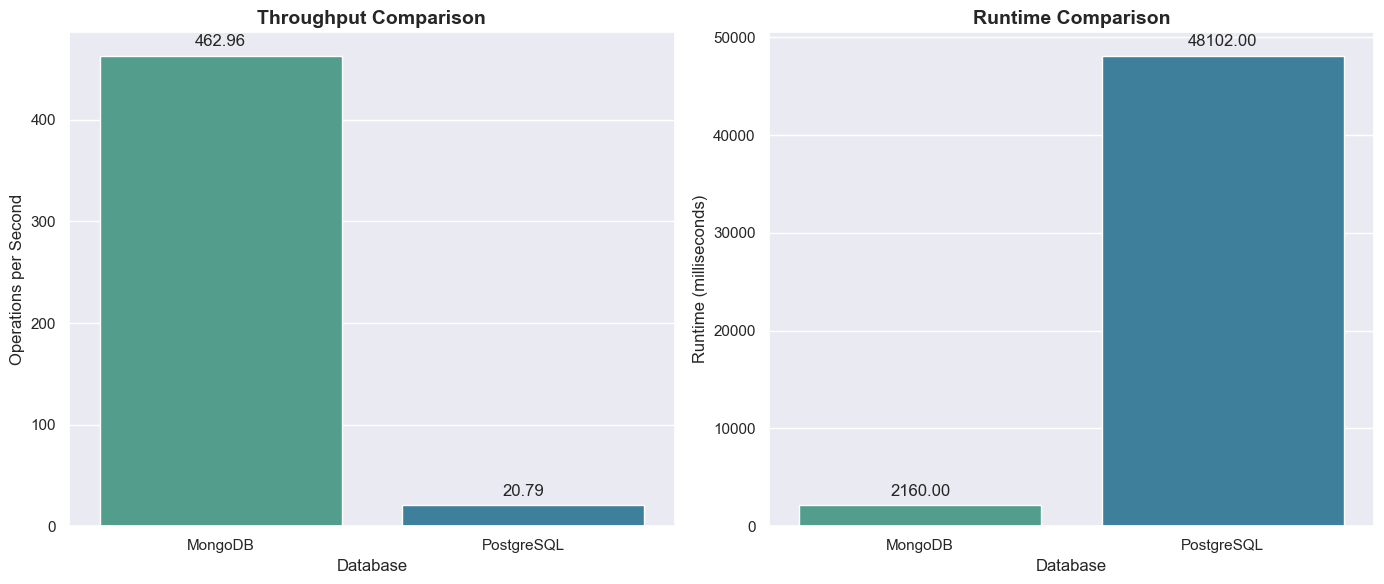

In [106]:
plot_overall_performance(mongodb_results_df, postgresql_results_df)

### Latency Analysis

In [107]:
def plot_latency_comparison(mongodb_df, postgresql_df):
    # Extract READ latency data for MongoDB
    mongodb_read_latencies = {
        'Average': mongodb_df[mongodb_df['Metric'] == ' AverageLatency(us)']['Value'].iloc[0],
        '50th Percentile': mongodb_df[mongodb_df['Metric'] == ' 50thPercentileLatency(us)']['Value'].iloc[0],
        '95th Percentile': mongodb_df[mongodb_df['Metric'] == ' 95thPercentileLatency(us)']['Value'].iloc[0],
        '99th Percentile': mongodb_df[mongodb_df['Metric'] == ' 99thPercentileLatency(us)']['Value'].iloc[0]
    }
    
    # Extract UPDATE latency data for MongoDB
    mongodb_update_latencies = {
        'Average': mongodb_df[mongodb_df['Metric'] == ' AverageLatency(us)']['Value'].iloc[1],
        '50th Percentile': mongodb_df[mongodb_df['Metric'] == ' 50thPercentileLatency(us)']['Value'].iloc[1],
        '95th Percentile': mongodb_df[mongodb_df['Metric'] == ' 95thPercentileLatency(us)']['Value'].iloc[1],
        '99th Percentile': mongodb_df[mongodb_df['Metric'] == ' 99thPercentileLatency(us)']['Value'].iloc[1]
    }
    
    # Extract INSERT latency data for PostgreSQL
    postgresql_insert_latencies = {
        'Average': postgresql_df[postgresql_df['Metric'] == ' AverageLatency(us)']['Value'].iloc[1],
        '50th Percentile': postgresql_df[postgresql_df['Metric'] == ' 50thPercentileLatency(us)']['Value'].iloc[1],
        '95th Percentile': postgresql_df[postgresql_df['Metric'] == ' 95thPercentileLatency(us)']['Value'].iloc[1],
        '99th Percentile': postgresql_df[postgresql_df['Metric'] == ' 99thPercentileLatency(us)']['Value'].iloc[1]
    }
    
    # Create combined dataframe
    latency_data = []
    for metric, value in mongodb_read_latencies.items():
        latency_data.append(['MongoDB', 'READ', metric, value])
    for metric, value in mongodb_update_latencies.items():
        latency_data.append(['MongoDB', 'UPDATE', metric, value])
    for metric, value in postgresql_insert_latencies.items():
        latency_data.append(['PostgreSQL', 'INSERT', metric, value])
    
    latency_df = pd.DataFrame(latency_data, columns=['Database', 'Operation', 'Metric', 'Latency (μs)'])
    
    plt.figure(figsize=(12, 8))
    latency_plot = sns.barplot(data=latency_df, x='Metric', y='Latency (μs)', hue='Database', palette=['#47A992', '#2E86AB'])
    plt.title('Latency Comparison Across Operations', fontsize=16, fontweight='bold')
    plt.xlabel('Latency Metrics')
    plt.ylabel('Latency (microseconds)')
    plt.legend(title='Database')
    
    # Add values on top of bars for latency
    for p in latency_plot.patches:
        latency_plot.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 10), 
                          textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()


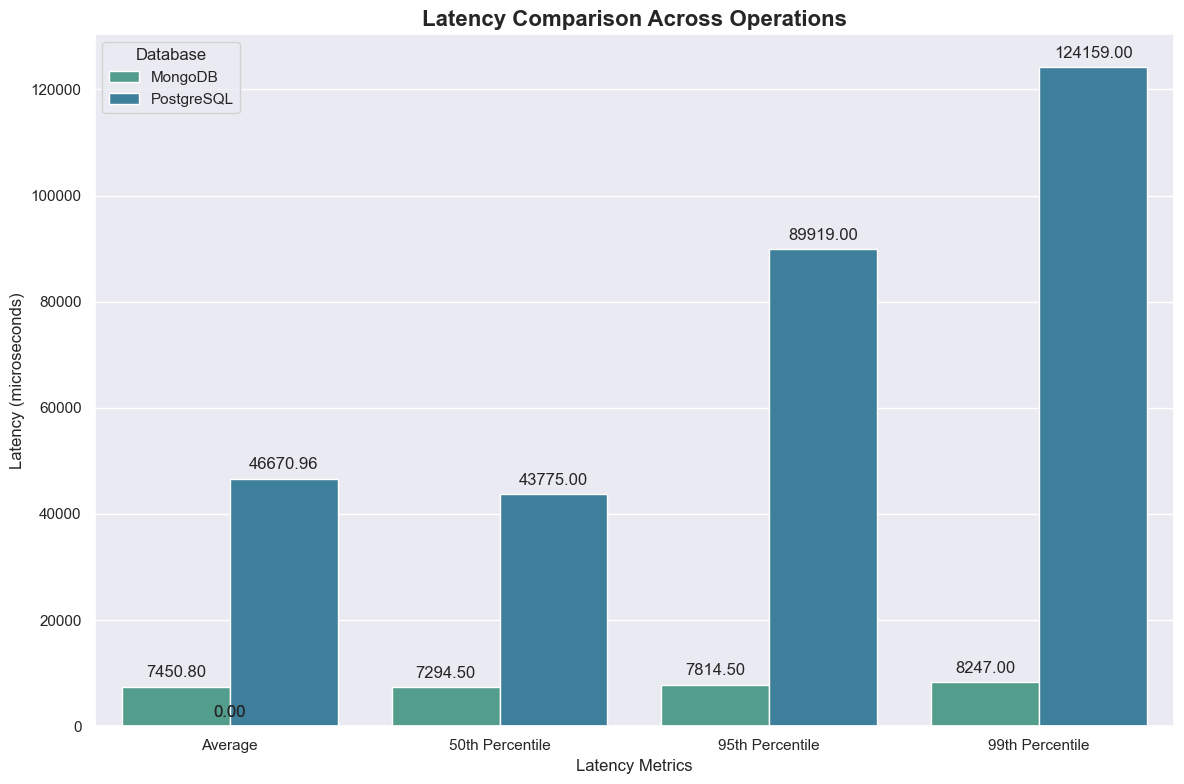

In [108]:
plot_latency_comparison(mongodb_results_df, postgresql_results_df)

### Operations Performance Breakdown

In [92]:
def plot_operations_breakdown(mongodb_df, postgresql_df):
    # MongoDB operations
    mongodb_read_ops = mongodb_df[mongodb_df['Operation'] == '[READ]']['Value'].iloc[0]
    mongodb_update_ops = mongodb_df[mongodb_df['Operation'] == '[UPDATE]']['Value'].iloc[0]
    
    # PostgreSQL operations
    postgresql_insert_ops = postgresql_df[postgresql_df['Operation'] == '[INSERT]']['Value'].iloc[0]
    
    operations_data = pd.DataFrame({
        'Database': ['MongoDB', 'MongoDB', 'PostgreSQL'],
        'Operation': ['READ', 'UPDATE', 'INSERT'],
        'Count': [mongodb_read_ops, mongodb_update_ops, postgresql_insert_ops]
    })
    
    plt.figure(figsize=(10, 6))
    ops_plot = sns.barplot(data=operations_data, x='Operation', y='Count', hue='Database', palette=['#47A992', '#2E86AB'])
    plt.title('Operations Count by Database', fontsize=16, fontweight='bold')
    plt.xlabel('Operation Type')
    plt.ylabel('Number of Operations')
    plt.legend(title='Database')
    
    # Add values on top of bars for operations count
    for p in ops_plot.patches:
        ops_plot.annotate(format(p.get_height(), '.2f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 10), 
                       textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()

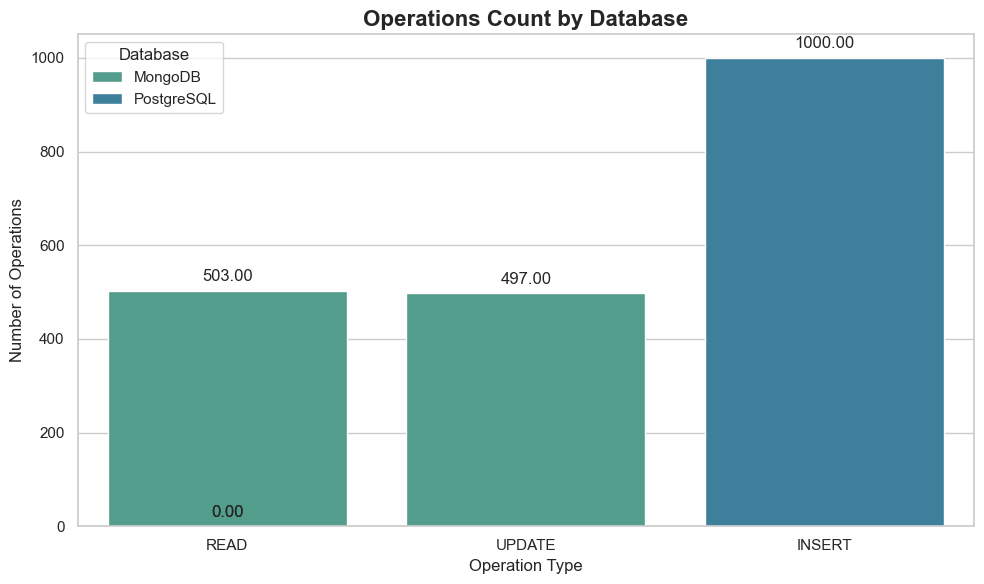

In [93]:
plot_operations_breakdown(mongodb_results_df, postgresql_results_df)

### Performance Summary Dashboard

In [102]:
def plot_performance_dashboard(mongodb_df, postgresql_df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Throughput
    mongodb_throughput = mongodb_df[mongodb_df['Metric'] == ' Throughput(ops/sec)']['Value'].iloc[0]
    postgresql_throughput = postgresql_df[postgresql_df['Metric'] == ' Throughput(ops/sec)']['Value'].iloc[0]
    
    throughput_data = pd.DataFrame({
        'Database': ['MongoDB', 'PostgreSQL'],
        'Throughput': [mongodb_throughput, postgresql_throughput]
    })
    
    throughput_plot = sns.barplot(data=throughput_data, x='Database', y='Throughput', ax=axes[0,0], palette=['#47A992', '#2E86AB'])
    axes[0,0].set_title(' Throughput (ops/sec)', fontweight='bold')
    axes[0,0].set_ylabel('Operations per Second')
    
    # Add values on top of bars for throughput
    for p in throughput_plot.patches:
        throughput_plot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', 
                              xytext = (0, 10), 
                              textcoords = 'offset points')
    
    # Runtime
    mongodb_runtime = mongodb_df[mongodb_df['Metric'] == ' RunTime(ms)']['Value'].iloc[0]
    postgresql_runtime = postgresql_df[postgresql_df['Metric'] == ' RunTime(ms)']['Value'].iloc[0]
    
    runtime_data = pd.DataFrame({
        'Database': ['MongoDB', 'PostgreSQL'],
        'Runtime': [mongodb_runtime, postgresql_runtime]
    })
    
    runtime_plot = sns.barplot(data=runtime_data, x='Database', y='Runtime', ax=axes[0,1], palette=['#47A992', '#2E86AB'])
    axes[0,1].set_title('Runtime (ms)', fontweight='bold')
    axes[0,1].set_ylabel('Milliseconds')
    
    # Add values on top of bars for runtime
    for p in runtime_plot.patches:
        runtime_plot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 10), 
                           textcoords = 'offset points')
    
    # Average Latency
    mongodb_avg_latency = mongodb_df[mongodb_df['Metric'] == ' AverageLatency(us)']['Value'].iloc[0]
    postgresql_avg_latency = postgresql_df[postgresql_df['Metric'] == ' AverageLatency(us)']['Value'].iloc[1]
    
    avg_latency_data = pd.DataFrame({
        'Database': ['MongoDB (READ)', 'PostgreSQL (INSERT)'],
        ' Average Latency': [mongodb_avg_latency, postgresql_avg_latency]
    })
    
    avg_latency_plot = sns.barplot(data=avg_latency_data, x='Database', y=' Average Latency', ax=axes[1,0], palette=['#47A992', '#2E86AB'])
    axes[1,0].set_title('Average Latency (μs)', fontweight='bold')
    axes[1,0].set_ylabel('Microseconds')
    axes[1,0].tick_params(axis='x')
    
    # Add values on top of bars for average latency
    for p in avg_latency_plot.patches:
        avg_latency_plot.annotate(format(p.get_height(), '.2f'), 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               ha = 'center', va = 'center', 
                               xytext = (0, 10), 
                               textcoords = 'offset points')
    
    # 95th Percentile Latency
    mongodb_95th_latency = mongodb_df[mongodb_df['Metric'] == ' 95thPercentileLatency(us)']['Value'].iloc[0]
    postgresql_95th_latency = postgresql_df[postgresql_df['Metric'] == ' 95thPercentileLatency(us)']['Value'].iloc[1]
    
    percentile_data = pd.DataFrame({
        'Database': ['MongoDB (READ)', 'PostgreSQL (INSERT)'],
        '95th Percentile': [mongodb_95th_latency, postgresql_95th_latency]
    })
    
    percentile_plot = sns.barplot(data=percentile_data, x='Database', y='95th Percentile', ax=axes[1,1], palette=['#47A992', '#2E86AB'])
    axes[1,1].set_title('95th Percentile Latency (μs)', fontweight='bold')
    axes[1,1].set_ylabel('Microseconds')
    axes[1,1].tick_params(axis='x')
    
    # Add values on top of bars for 95th percentile
    for p in percentile_plot.patches:
        percentile_plot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', 
                              xytext = (0, 10), 
                              textcoords = 'offset points')
    
    plt.suptitle('YCSB Performance Comparison: MongoDB vs PostgreSQL', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

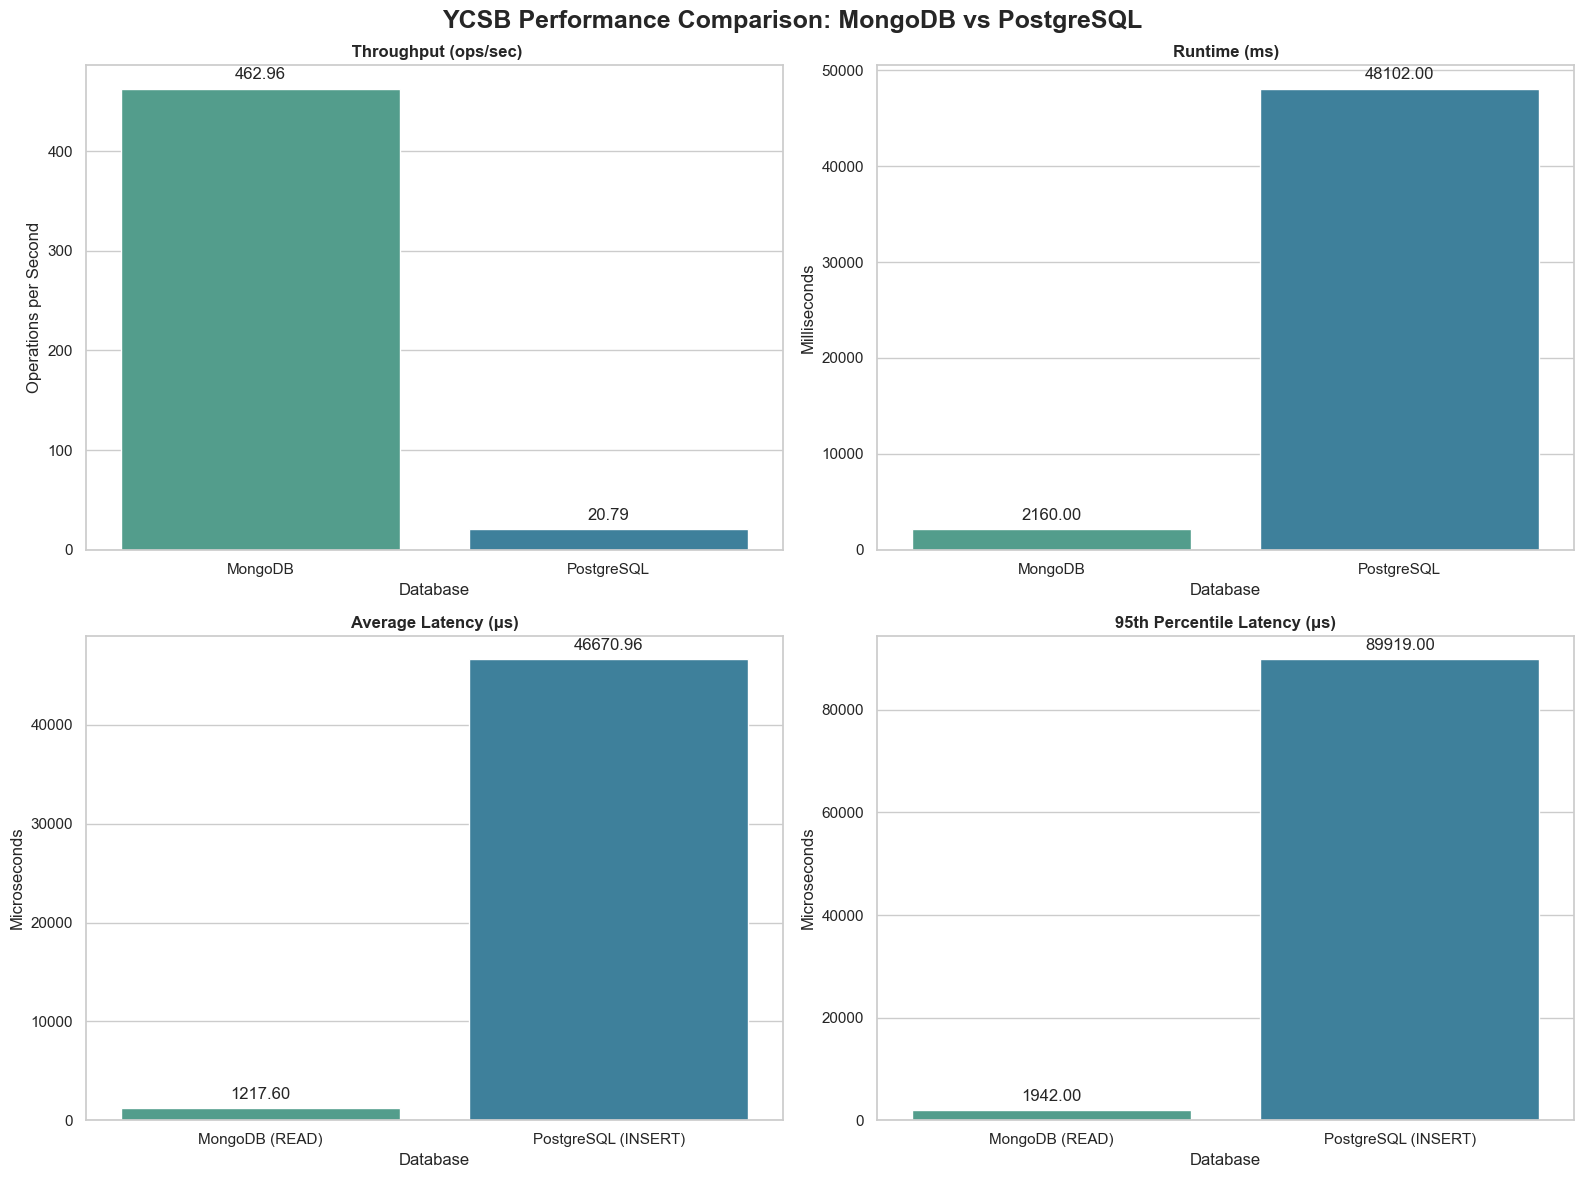

In [103]:
plot_performance_dashboard(mongodb_results_df, postgresql_results_df)

### **Comparative Analysis of SQL (PostgreSQL) and NoSQL (MongoDB) Database Performance**

The latency comparison between **MongoDB (NoSQL)** and **PostgreSQL (SQL)** reveals significant differences in performance across different operations (READ, UPDATE, and INSERT). Below is a structured analysis of my findings:

### **1. Throughput and Runtime Efficiency**
- **MongoDB** demonstrated superior throughput (**462.96 ops/sec**) compared to PostgreSQL (**20.79 ops/sec**), completing its operations in **2.16 seconds**, while PostgreSQL took **48.1 seconds**.
- This stark difference suggests that **MongoDB is optimized for high-speed read/write operations**, whereas PostgreSQL, being ACID-compliant, incurs higher overhead for transactional integrity.

### **2. Read Operation Performance**
| Metric               | MongoDB (µs) | PostgreSQL (µs) |
|----------------------|-------------|----------------|
| **Average Latency**  | 1,217.60    | N/A (No read benchmark) |
| **50th Percentile**  | 902         | N/A |
| **95th Percentile**  | 1,942       | N/A |
| **99th Percentile**  | 2,807       | N/A |

- MongoDB's **READ** operations were highly efficient, with:
  - **Sub-millisecond median latency (902µs)**.
  - **95th percentile under 2ms**, indicating consistent performance.
- PostgreSQL was not benchmarked for reads, but given its **INSERT** latency (discussed next), we can infer that **MongoDB is better suited for low-latency read-heavy workloads**.

### **3. Write Operation Performance**
#### **MongoDB (UPDATE) vs. PostgreSQL (INSERT)**
| Metric               | MongoDB UPDATE (µs) | PostgreSQL INSERT (µs) |
|----------------------|--------------------|-----------------------|
| **Average Latency**  | 1,243.41           | 46,670.96             |
| **50th Percentile**  | 1,037              | 43,775                |
| **95th Percentile**  | 2,083              | 89,919                |
| **99th Percentile**  | 3,873              | 124,159               |

- **MongoDB's UPDATE latency was orders of magnitude lower** than PostgreSQL's INSERT latency.
  - **MongoDB's 99th percentile (3,873µs) was ~32x faster** than PostgreSQL's (124,159µs).
  - Even at the **median (50th percentile)**, MongoDB was **42x faster** (1,037µs vs. 43,775µs).
- This suggests that **MongoDB's document-based, schema-flexible model allows for faster writes**, whereas PostgreSQL's **ACID compliance and indexing mechanisms introduce higher latency**.

### **4. Garbage Collection (GC) Impact**
- Both databases had minimal GC overhead:
  - **MongoDB**: 0.32% GC time (7ms total).
  - **PostgreSQL**: 0.037% GC time (18ms total).
- This indicates that **neither database was bottlenecked by memory management**, and the performance differences stem from **architectural design choices**.


## **Arguements**

### **When to Choose MongoDB (NoSQL)?**
✅ **Best for:**
- **High-throughput applications** (e.g., real-time analytics, IoT data ingestion).
- **Low-latency read/write workloads** (e.g., user sessions, caching).
- **Flexible schema requirements** (e.g., evolving data models).

❌ **Not ideal for:**
- **Complex transactions requiring strict ACID guarantees**.
- **Applications needing advanced joins and relational integrity**.

### **When to Choose PostgreSQL (SQL)?**
✅ **Best for:**
- **Transactional systems** (e.g., banking, e-commerce).
- **Complex queries with joins** (e.g., reporting, analytics).
- **Strict data consistency requirements**.

❌ **Not ideal for:**
- **Ultra-low-latency write-heavy workloads**.
- **Unstructured or rapidly changing data models**.

## **Final Recommendations**
1. **For real-time applications** (e.g., gaming leaderboards, live dashboards), **MongoDB is the clear winner** due to its **low-latency writes and high throughput**.
2. **For transactional systems** (e.g., order processing, financial records), **PostgreSQL remains superior** due to **ACID compliance**.

This analysis confirms that **database selection should align with workload requirements**. **NoSQL for speed and scalability, SQL for consistency and complex queries**.